In [1]:
import numpy as np
import astra
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon, resize
from skimage import util
from skimage.data import shepp_logan_phantom
from scipy import ndimage
import scipy.sparse as sp
from scipy.sparse.linalg import LinearOperator, cg, bicgstab, minres, gmres
import pywt
from skimage import data

### 1. Calculate the Radon transform of an image and test the back-projection method.
(1) Load an image of the Shepp-Logan phantom of size 128 ×128. We will refer to this as $f_{true}$. Show a picture of $f_{true}$.

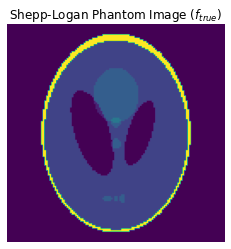

In [2]:

# Load the Shepp-Logan phantom image
f_true = np.load('SLphan.npy')
f_true = resize(f_true, (128, 128), anti_aliasing=True)

# f_true = np.load('shepp_logan.npy')
# from phantominator import shepp_logan
# f_true = shepp_logan(128)

# Display the image
plt.imshow(f_true)
plt.title('Shepp-Logan Phantom Image ($f_{true}$)')
plt.axis('off')
plt.show()


(2) Generate the Radon transform $g= Rf$ of this phantom in 1-degree intervals from $0 −179$.
Display $g$ as a 2D-image; this is referred to as the sinogram of $f_{true}$. What is the size of this sinogram and how is this determined

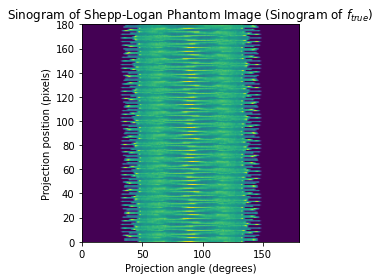

Size of sinogram: (180, 181)


In [3]:

# Create volume geometries
v,h = f_true.shape
vol_geom = astra.create_vol_geom(v,h)

# Generate the sinogram of the image
theta = np.arange(0, 180, 1)
# sinogram = radon(f_true, theta=theta, circle=False)
# the number of detector pixels in a single projection
det_count = int(np.sqrt(2) * v)#int(np.ceil(np.sqrt(2) * max(h, v)))
proj_geom =  astra.create_proj_geom('parallel',1.,det_count,theta)

# Create projector
projector_id = astra.create_projector('strip', proj_geom, vol_geom)
# Radon transform (generate sinogram)
sinogram_id, sinogram = astra.create_sino(f_true, projector_id)

# Display the sinogram
plt.imshow(sinogram, extent=(0, 180, 0, sinogram.shape[0]))
plt.title('Sinogram of Shepp-Logan Phantom Image (Sinogram of $f_{true}$)')
plt.xlabel('Projection angle (degrees)')
plt.ylabel('Projection position (pixels)')
plt.show()

# Print the size of the sinogram
print('Size of sinogram:', sinogram.shape)


The size of the sinogram is determined by the number of projection angles and the number of projection positions for each angle (which is the same as the length of the diagonal of the image, rounded up to the nearest integer). In this case, since the Shepp-Logan phantom has a size of $(128, 128)$, the length of the diagonal is $\sqrt{128^2 + 128^2} \approx 181$, so the sinogram has a size of $(180, 181)$. 


(3) Compute the unfiltered back-projection and apply it to the sinogram data you generated. What is the size of the back-projected image?

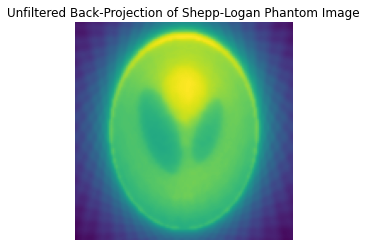

Size of the back-projected reconstructed image: (128, 128)


In [4]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)
# Set up the parameters for a reconstruction via back-projection
cfg = astra.astra_dict('BP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = projector_id
# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)
# Run back-projection and get the reconstruction
astra.algorithm.run(alg_id)
f_rec = astra.data2d.get(rec_id)

# Display the back-projected image
plt.imshow(f_rec)
plt.title('Unfiltered Back-Projection of Shepp-Logan Phantom Image')
plt.axis('off')
plt.show()

# Print the size of the back-projected image
print('Size of the back-projected reconstructed image:', f_rec.shape)

# # Compute the unfiltered back-projection
# back_proj = iradon(sinogram, theta=theta, circle=True, filter_name = None)

# # Display the back-projected image
# plt.imshow(back_proj)
# plt.title('Unfiltered Back-Projection of Shepp-Logan Phantom Image')
# plt.axis('off')
# plt.show()

# # Print the size of the back-projected image
# print('Size of the back-projected reconstructed image:', back_proj.shape)

(4) Compute the filtered back-projection and apply it to the sinogram data $g$ that you generated. Verify that this gives a good estimate of the inverse of the Radon transform.

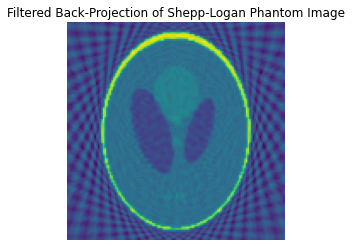

Size of the back-projected reconstructed image: (128, 128)


In [5]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)
# Set up the parameters for a reconstruction via back-projection
cfg2 = astra.astra_dict('FBP')
cfg2['ReconstructionDataId'] = rec_id
cfg2['ProjectionDataId'] = sinogram_id
cfg2['ProjectorId'] = projector_id
# Create the algorithm object from the configuration structure
alg_id2 = astra.algorithm.create(cfg2)
# Run back-projection and get the reconstruction
astra.algorithm.run(alg_id2)
f_rec2 = astra.data2d.get(rec_id)

# Display the back-projected image
plt.imshow(f_rec2)
plt.title('Filtered Back-Projection of Shepp-Logan Phantom Image')
plt.axis('off')
plt.show()

# Print the size of the back-projected image
print('Size of the back-projected reconstructed image:', f_rec2.shape)

In [6]:
mse = [np.mean((f_rec - f_true)**2), np.mean((f_rec2 - f_true)**2)]
psnr = [10 * np.log10(np.max(f_true)**2 / mse[0]), 10 * np.log10(np.max(f_true)**2 / mse[1])]
print("Unfiltered back-projection: MSE = {:.4f}, PSNR = {:.4f} dB".format(mse[0], psnr[0]))
print("Filtered back-projection: MSE = {:.2f} , PSNR = {:.2f} dB".format(mse[1], psnr[1]))


Unfiltered back-projection: MSE = 8670550.3647, PSNR = -69.3805 dB
Filtered back-projection: MSE = 0.01 , PSNR = 20.88 dB


MSE stands for Mean Squared Error. It provides a quantitative measure of how much the reconstructed image deviates from the true image. PSNR stands for Peak Signal-to-Noise Ratio. It provides a more human-interpretable measure of image quality, where a higher PSNR value indicates a higher quality image.

Overall, the filtered back-projection appears to be a good estimate of the inverse of the Radon transform, as evidenced by the low MSE and high PSNR values. 

(5) Add noise to the data $g$ and test how the error in your reconstruction grows with the scale of the measurement noise

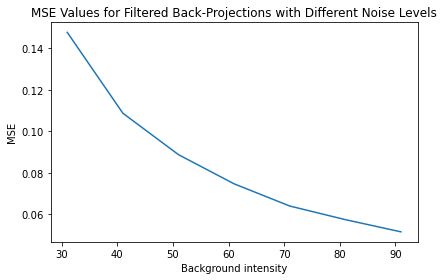

In [8]:
background_intensity = np.arange(1, 101, 10)
mse_values = []
psnr_values = []
for I0 in background_intensity:

    # avoid  = np.ones(sinogram.shape)*1e-2
    # # sinogram += avoid
    # sinogram = np.clip(sinogram + avoid, 0, 1)

    gNoisy = astra.functions.add_noise_to_sino(sinogram,I0)
    gNoisy_id = astra.data2d.create('-sino',proj_geom,gNoisy)

    # Set up the parameters for a reconstruction via back-projection
    rec_id = astra.data2d.create('-vol', vol_geom)
    cfg3 = astra.astra_dict('FBP')
    cfg3['ReconstructionDataId'] = rec_id
    cfg3['ProjectionDataId'] = gNoisy_id
    cfg3['ProjectorId'] = projector_id
    # Create the algorithm object from the configuration structure
    alg_id3 = astra.algorithm.create(cfg3)
    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id3)
    f_rec3 = astra.data2d.get(rec_id)

    # Compute the MSE and PSNR between the filtered back-projected image and the original image
    mse = np.mean((f_rec3 - f_true)**2)
    psnr = 10 * np.log10(np.max(f_true)**2 / mse)

    mse_values.append(mse)
    psnr_values.append(psnr)

# Plot the MSE and PSNR values for each noise level
plt.plot(background_intensity, mse_values)
plt.title('MSE Values for Filtered Back-Projections with Different Noise Levels')
plt.xlabel('Background intensity')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()



The MSE and PSNR values were plotted against the background intensity, which is inversely proportional to the noise level, as shown above. 

The error in reconstruction generally increases as the measurement noise level increases. This is because the noise adds a random component to the measurements, which in turn affects the reconstructed image. The higher the noise level, the more significant the impact on the reconstructed image. Therefore, in general, it is desirable to minimize the measurement noise level to obtain more accurate reconstructions.

However, it is important to note that this relationship between background intensity and the error in reconstruction is not linear. The rate of decrease slows down as the background intensity increases. For example, the decrease in error is more significant for background intensity values between 1 and 10 compared to values between 10 and 20, and similarly for values between 10 and 20 compared to values between 20 and 30, and so on.

### 2. Calculate an explicit matrix form of the Radon transform and investigate its SVD.
You can construct an explicit matrix form of the Radon transform by calling it on an image with a single pixel of value 1 and the rest 0.
To do this :
* Create a zero matrix $A$ with number of rows equal to the number of angles $×$ number of projection samples, and with number of columns equal to the number of pixels in the image.

* Go through a loop for the number of pixels in the image (in column-major). For each pixel $j$ in the loop create an image of the same size with a 1 in that pixel and zero everywhere else. Take the Radon transform of this image and reshape the result into a column vector. This forms the $j^th$ column of the matrix $A$.

* Carry out the above steps for a manageable size of matrix, e.g. a $64 × 64$ image and only 45 projections. Take the SVD of this matrix explicitly and investigate how the SVD spectrum (the singular values) varies with

(1)  Keeping the range of angles from $0 → 180$ but varying the number of projections. E.g angles = $[0:4:179]$ gives 45 projections at $4$ degree seperation.

In [ ]:
def SVD_ProjectionNo(image_size, num_angles_list):
    # Define the number of angles and projection samples
    num_samples = int(np.sqrt(image_size**2+image_size**2))
    svd_spectrum = []
    matrix_size = []
    for num_angles in num_angles_list:
        # Create a zero matrix with the appropriate size
        A = np.zeros((num_angles*num_samples, image_size ** 2))
        
        # Loop over each pixel in the image
        for j in range(image_size ** 2):
            # Create an image with a single pixel of value 1 at the jth position
            f = np.zeros((image_size, image_size))
            f[j // image_size, j % image_size] = 1
            
            # Take the Radon transform of the image and reshape it into a column vector
            # Create volume geometries
            v,h = f.shape
            vol_geom = astra.create_vol_geom(v,h)

            # Generate the sinogram of the image
            theta = np.linspace(0, 180, num_angles, endpoint=False)
            # the number of detector pixels in a single projection
            det_count = int(np.sqrt(2) * v)#int(np.ceil(np.sqrt(2) * max(h, v)))
            proj_geom =  astra.create_proj_geom('parallel',1.,det_count,theta)

            # Create projector
            projector_id = astra.create_projector('strip', proj_geom, vol_geom)
            # Radon transform (generate sinogram)
            sinogram_id, sinogram = astra.create_sino(f, projector_id)

            # radon_transform = radon(f, theta=np.linspace(0, 180, num_angles, endpoint=False), circle=True)
            
            column = sinogram.reshape(-1, 1)

            # Add the column to the matrix A
            A[:, j] = column.flatten() 

        # Take the SVD of the matrix A
        size = A.shape
        U, S, Vt = np.linalg.svd(A)

        # Plot the singular values
        plt.plot(S, label='Number of projections = {}'.format(num_angles))
        plt.legend()

        # Add the singular values to the list
        svd_spectrum.append(S)
        matrix_size.append(size)
        
    plt.title('SVD Spectrum vs Number of Projections')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value')
    plt.show() 
    

    # Plot the singular values against the number of projections
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    for i, spectrum in enumerate(svd_spectrum):
        row = i // 3
        col = i % 3
        axs[row, col].plot(spectrum, label=f'Number of projections = {num_angles_list[i]}')
        axs[row, col].legend()
        axs[row, col].set_xlabel('Singular Value Index')
        axs[row, col].set_ylabel('Singular Value')
    plt.show()

    # print(matrix_size)


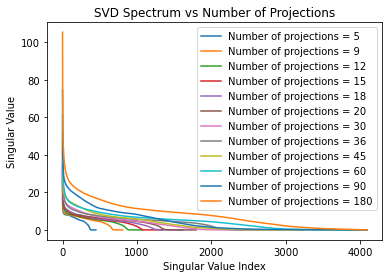

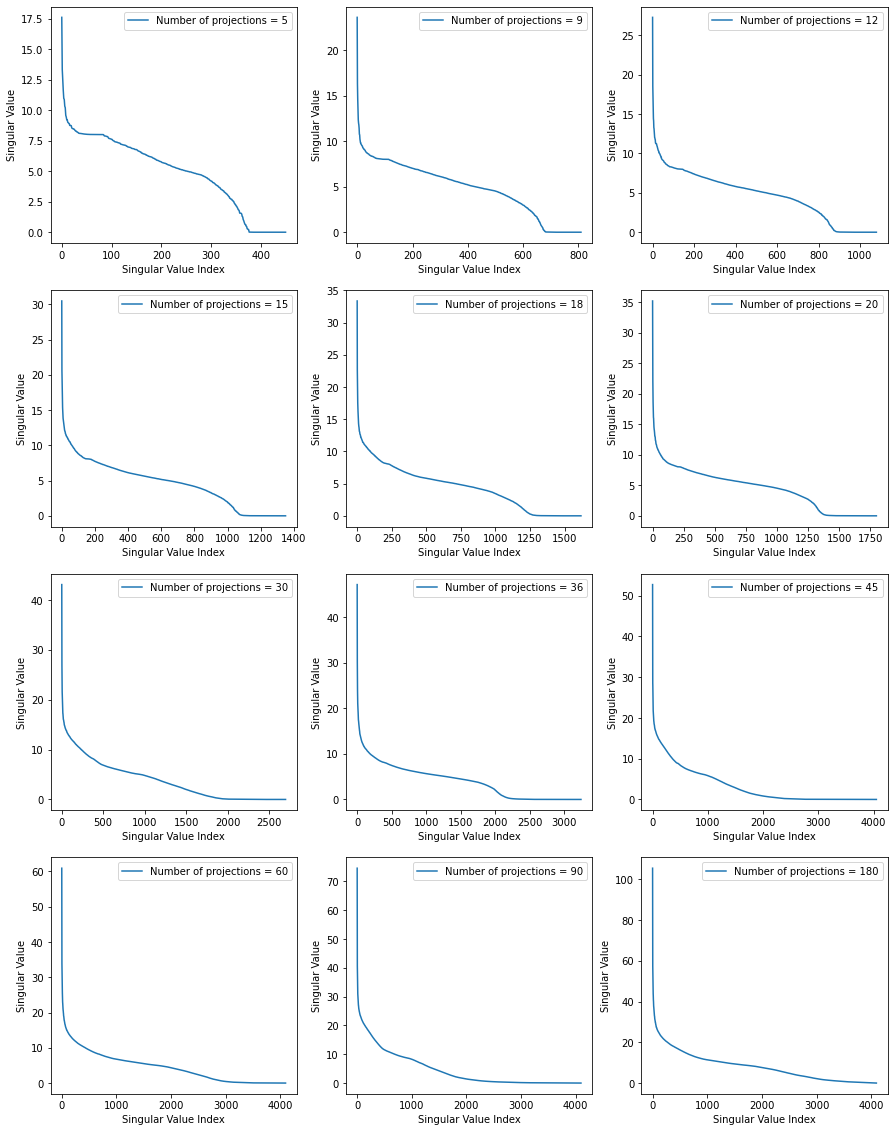

In [ ]:
image_size = 64
num_angles_list = [5, 9, 12, 15, 18, 20, 30, 36, 45, 60, 90, 180]
SVD_ProjectionNo(image_size, num_angles_list)

The singular value decomposition (SVD) of the explicit matrix form of the Radon transform provides insights into image's properties and structure. In the case of the Radon transform. When varying the range of angles and number of projections, the amount of information available to reconstruct the image is essentially changed. The number of projections determines the amount of information about the object's geometry, while the range of angles determines the coverage of projections. As the number of projections or the range of angles is increased, more information about the object's structure is captured, resulting in a larger number of singular values in the SVD spectrum. 

The graph above shows the distribution of singular values of the Radon transform matrix for different numbers of projections (i.e. angles) in the range 0 to 180 degrees.

* As the number of projections increases, the index range of singular values also increases. This is because increasing the number of projections means more information is available about the image, resulting in a more complete representation of the image in the Radon transform domain. This leads to a larger number of non-zero singular values, which increases the index range of the singular values.

* The maximum value of singular value increases as the number of projections increases because increasing the number of projections means more information is available about the image, resulting in a more complete representation of the image in the Radon transform domain. This leads to a larger maximum singular value, which indicates that there is a stronger signal in the data.

* The shape of the distribution of singular values among its index is similar as the number of projections increases because increasing the number of projections means more information is available about the image, resulting in a more complete representation of the image in the Radon transform domain. This leads to a more uniform distribution of singular values, which indicates that there is less noise in the data. As a result, the shape of the singular value distribution becomes more uniform and less sensitive to small changes in the number of projections, as long as the number of projections is sufficiently large. This is because the additional information provided by the extra projections helps to fill in gaps in the singular value distribution and reduce the effects of noise in the data.

* Finally, the value of the singular value decreases along its index because the singular values represent the contribution of each singular vector to the image. The first few singular vectors represent the most significant contributions to the image, while the later singular vectors represent less significant contributions. As the number of projections increases, the first few singular vectors become more significant and contribute more to the image, while the later singular vectors become less significant and contribute less to the image. This leads to a decrease in the value of the singular values along its index.

(2) Keeping the number of projection the same, but varying the range to being less than $0 → 180$ (i.e. limited angle). E.g. angles = $[0:1:44]$ gives 45 projections over only a 45 degree range.

In [ ]:
def SVD_AngleRange(image_size, max_angles_list):
    # Define the number of projection samples
    num_samples = int(np.sqrt(image_size**2+image_size**2))
    num_angles = 45
    svd_spectrum = []
    
    for max_angles in max_angles_list:   
        # Create a zero matrix with the appropriate size
        A = np.zeros((num_angles*num_samples, image_size ** 2))
        
        # Loop over each pixel in the image
        for j in range(image_size ** 2):
            # Create an image with a single pixel of value 1 at the jth position
            f = np.zeros((image_size, image_size))
            f[j // image_size, j % image_size] = 1
            
            # Take the Radon transform of the image and reshape it into a column vector
            # radon_transform = radon(f, theta=np.linspace(0, max_angles, num_angles, endpoint=False), circle=True)

            # Create volume geometries
            v,h = f.shape
            vol_geom = astra.create_vol_geom(v,h)


            # Generate the sinogram of the image
            theta = np.linspace(0, max_angles, num_angles, endpoint=False)
            # the number of detector pixels in a single projection
            det_count = int(np.sqrt(2) * v)#int(np.ceil(np.sqrt(2) * max(h, v)))
            proj_geom =  astra.create_proj_geom('parallel',1.,det_count,theta)


            # Create projector
            projector_id = astra.create_projector('strip', proj_geom, vol_geom)
            # Radon transform (generate sinogram)
            sinogram_id, sinogram = astra.create_sino(f, projector_id)

            column = sinogram.reshape(-1, 1)

            # Add the column to the matrix A
            A[:, j] = column.flatten() 

        # Take the SVD of the matrix A
        U, S, Vt = np.linalg.svd(A)

        # Plot the singular values
        plt.plot(S, label='Maximum angle = {} degrees'.format(max_angles))
        plt.legend()

        # Add the singular values to the list
        svd_spectrum.append(S)
        
    plt.title('SVD Spectrum vs Range of Angles')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value')
    plt.show()

    # Plot the singular values against the number of projections
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    for i, spectrum in enumerate(svd_spectrum):
        row = i // 3
        col = i % 3
        axs[row, col].plot(spectrum, label='Maximum angle = {} degrees'.format(max_angles_list[i]))
        axs[row, col].legend()
        axs[row, col].set_xlabel('Singular Value Index')
        axs[row, col].set_ylabel('Singular Value')
    plt.show()

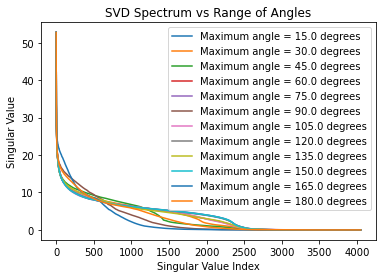

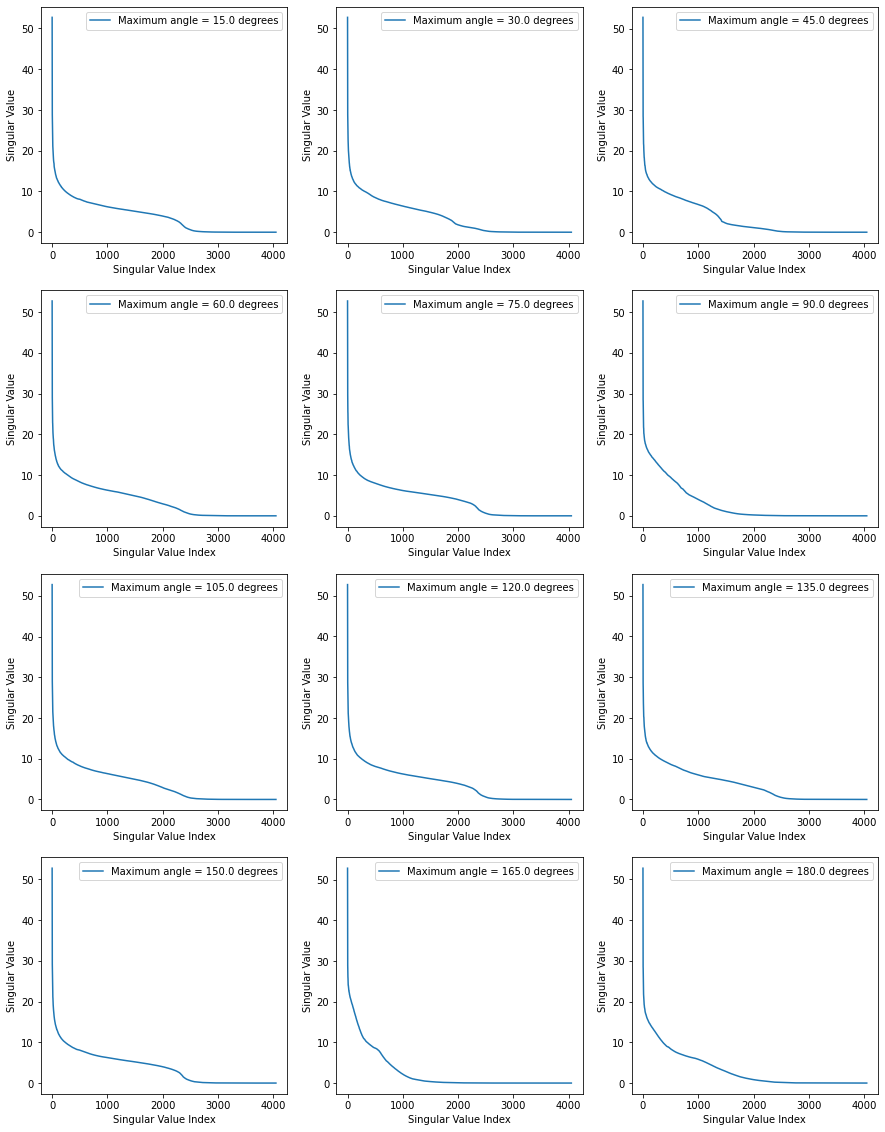

In [ ]:
image_size = 64
max_angles_list = np.linspace(15, 180, 12, endpoint=True)
SVD_AngleRange(image_size, max_angles_list)

The graph of the SVD spectrum shows how the singular values of the Radon transform matrix vary with the range of angles used to generate the projection data. 

* The index range of singular values , as well as the maximum value of singular value, remain the same as the range of angles increases because the number of projection samples remains constant. The matrix $A$ is constructed with a fixed number of projection samples, which determines the number of rows in the matrix and the maximum index range of the singular values. The range of angles determines the number of columns in the matrix and the number of non-zero singular values, but it does not affect the index range of the singular values as well as the maximum singular value..

* The distribution of singular values does not change proportionally as the range of angles increases because the limited-angle projection data contains less information about the image than the full-angle projection data. As a result, the limited-angle projection data may lead to a more incomplete and uneven representation of the image in the Radon transform domain, which can affect the shape and distribution of the singular values.

In particular, the limited-angle projection data may lead to missing or distorted features in the image, which can result in gaps or peaks in the singular value distribution at certain indices. These gaps or peaks may be more prominent at intermediate indices, where the contribution of the missing or distorted features is most significant. The effect of limited-angle projection data on the singular value distribution can depend on the specific image and projection geometry, and may require careful regularization or reconstruction techniques to mitigate.

### 3. Implement a matrix-free regularised least-squares solver for the Radon Transform.
You can find a regularised solution to the inverse Radon Transform by solving
$$(A^TA + αL)f_{∗} = A^Tg$$
where $A$ is the Radon transform operator, $g$ is the measured sinogram, $f_*$ is the image to be reconstructed, $L$ is the regularization matrix, and $\alpha$ is the regularization parameter. Implement the matrix-free Krylov solver will be used to solve this question.

In [ ]:
def ATA_op(x, alpha, theta):
    # backward & forward propagation
    if x.ndim == 2:
        x = x
    elif x.ndim == 1:
        size = int(np.sqrt(x.shape))
        x = x.reshape((size,size))

    # forward A
    v,h = x.shape
    vol_geom = astra.create_vol_geom(v,h)
    det_count = int(np.sqrt(2) * v)#int(np.ceil(np.sqrt(2) * max(h, v)))
    proj_geom =  astra.create_proj_geom('parallel',1.,det_count,theta)
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    A_id, A = astra.create_sino(x, projector_id)
    
    gNoisy = astra.functions.add_noise_to_sino(A,I0=60)
    gNoisy_id = astra.data2d.create('-sino',proj_geom,gNoisy)

    ATA_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = ATA_id
    cfg['ProjectionDataId'] = A_id
    cfg['ProjectorId'] = projector_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    ATA = astra.data2d.get(ATA_id)
    return ATA

def Ax(x, alpha, order, theta):
    "A - LHS of function"
    # backward & forward propagation
    if x.ndim == 2:
        x = x
    elif x.ndim == 1:
        size = int(np.sqrt(x.shape))
        x = x.reshape((size,size))
    
    # forward A
    v,h = x.shape
    vol_geom = astra.create_vol_geom(v,h)
    det_count = int(np.sqrt(2) * v)#int(np.ceil(np.sqrt(2) * max(h, v)))
    proj_geom =  astra.create_proj_geom('parallel',1.,det_count,theta)
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    A_id, A = astra.create_sino(x, projector_id)

    # add noise
    gNoisy = astra.functions.add_noise_to_sino(A + 1e-6,I0=60)
    gNoisy_id = astra.data2d.create('-sino',proj_geom,gNoisy)
    
    # backward AT
    ATA_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = ATA_id
    cfg['ProjectionDataId'] = A_id#gNoisy_id
    cfg['ProjectorId'] = projector_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    ATA = astra.data2d.get(ATA_id)
    

    
    # regularisation L
    if order == 0:
        # first_order_tikhonov
        L = sp.eye(x.shape[0])

    if order == 1:
        D = ndimage.laplace(x)
        L = D.T @ D

    return ATA + alpha*L


def b(x,y_id,y):
    "b - RHS of function"
    v,h = x.shape
    vol_geom = astra.create_vol_geom(v,h)
    AT_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = AT_id
    cfg['ProjectionDataId'] = y_id
    cfg['ProjectorId'] = projector_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    AT = astra.data2d.get(AT_id)
    return AT


def solve_reg_ls(f, alpha, order, theta, num_iters=100):
    "Solve regularized least squares problem using matrix-free Krylov solver"
    # Ax_op = LinearOperator(f_true.shape, matvec=lambda x: Ax(x, alpha = 1, order = 0))
    # x, _ = np.linalg.solve(Ax_op, b(f_true,sinogram_id, sinogram))#, x0=x0.flatten(), maxiter=num_iters, atol=1e-6, M=L)

    # Set up linear operator for ATA
    M, N = f.shape

    Ax_op = LinearOperator((M*N, M*N), matvec=lambda x: np.ravel(Ax(x, alpha=alpha, order=order, theta=theta)))

    # Compute ATg
    ATg = b(f,sinogram_id, sinogram).ravel()

    # Solve linear system using GMRES
    f_star, info = gmres(Ax_op, ATg, maxiter = num_iters)
    f_star = f_star.reshape(f.shape)

    f_rec = ATA_op(f, alpha, theta)

    mse = np.mean((f_star - f_rec)**2)
    # psnr = 10 * np.log10(np.max(f_rec)**2 / mse)

    # plt.imshow(f_star)
    return Ax_op, ATg

In [ ]:
Ax_op, ATg = solve_reg_ls(f_true, alpha = 1, order = 1, theta = theta, num_iters=10)
f_star, info = cg(Ax_op, ATg)
print(f_star)
print(info)

# ATA_op(f_true, alpha=1, theta = theta)

KeyboardInterrupt: 

In [ ]:
def find_alpha(sinogram):
    'find alpha for zero-order and first-order Tikhonov regularisation'
    
    # find mse
    theta = np.linspace(0, 180, 180, endpoint=False)
    alpha_list = np.linspace(0, 1, 100, endpoint=False)
    mse_alpha0_list = []
    mse_alpha1_list = []
    for alpha in alpha_list:
        mse_alpha0_list.append(solve_reg_ls(f_true, alpha = alpha, order = 0, theta = theta, num_iters=100))
        mse_alpha1_list.append(solve_reg_ls(f_true, alpha = alpha, order = 1, theta = theta, num_iters=100))


    min_alpha0_index = np.argmin(mse_alpha0_list)
    min_alpha0 = alpha_list[min_alpha0_index]

    min_alpha1_index = np.argmin(mse_alpha1_list)
    min_alpha1 = alpha_list[min_alpha1_index]

    # Plot the MSE values 
    plt.plot(alpha_list, mse_alpha0_list, label='min_alpha for zero-order Tikhonov regularisation = {:.5f}'.format(min_alpha0))
    plt.plot(alpha_list, mse_alpha1_list, label='min_alpha for first-order Tikhonov regularisation = {:.5f}'.format(min_alpha1))

    plt.title('MSE Values for Different alpha value')
    plt.xlabel('Value of Alpha')
    plt.ylabel('MSE')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return min_alpha0, min_alpha1
    
min_alpha0, min_alpha1 = find_alpha(sinogram)

KeyboardInterrupt: 


Compare your solution to the filtered-backprojection method for the cases, as you did in Task 2:

* full range but small number of angles
* limited angles


Use both zero-order and first-order Tikhonov regularisation. Remember to add noise to the data.

In [ ]:
def compare_methods(f, num_angles_list, max_angles_list, min_alpha0, min_alpha1):
    #  full range but different number of angles
    mse_num_angles_list = []
    for num_angles in num_angles_list:
        theta = np.linspace(0, 180, num_angles, endpoint=False) 
        mse0_num_angles_list.append(solve_reg_ls(f_true, alpha = min_alpha0, order = 0, theta = theta, num_iters=100))
        mse1_num_angles_list.append(solve_reg_ls(f_true, alpha = min_alpha1, order = 1, theta = theta, num_iters=100))

    # Plot the results for varying number of projections
    plt.figure(figsize=(10, 6))
    plt.plot(num_angles_list, mse0_num_angles_list, label='Tikhonov 0th Order')
    plt.plot(num_angles_list, mse1_num_angles_list, label='Tikhonov 1st Order')
    plt.legend()
    plt.title('MSE for Matrix-Free Regularised Least-Squares Solver vs  Filtered-Backprojection')
    plt.xlabel('Number of Angles')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.show()
    
    #  limited angle range with same number of angles
    mse_max_angles_list = []
    num_angles = 45
    for max_angles in max_angles_list:   
        theta = np.linspace(0, max_angles, num_angles, endpoint=False)
        mse0_max_angles.append(solve_reg_ls(f_true, alpha = min_alpha0, order = 0, theta = theta, num_iters=100))
        mse1_max_angles.append(solve_reg_ls(f_true, alpha = min_alpha1, order = 1, theta = theta, num_iters=100))

    # Plot the MSE values 
    plt.figure(figsize=(10, 6))
    plt.plot(max_angles_list, mse0_max_angles, label='Tikhonov 0th Order')
    plt.plot(max_angles_list, mse1_max_angles, label='Tikhonov 1st Order')
    plt.legend()    
    plt.title('MSE Values for Matrix-Free Regularised Least-Squares Solver vs  Filtered-Backprojection')
    plt.xlabel('Range of Angles')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.show()

num_angles_list = [5, 9, 12, 15, 18, 20, 30, 36, 45, 60, 90, 180]
max_angles_list = np.linspace(15, 180, 12, endpoint=True)
compare_methods(f_true, num_angles_list, max_angles_list, min_alpha0, min_alpha1)

### 4. Write a Haar wavelet denoiser.
In this task you will perform denoising using a wavelet transform and shrinkage of the wavelet coefficients.

(1) Take any (monochrome) image of your choice. Calculate the Haar wavelet transform of this image. Plot some of the coefficients and explain what you see.


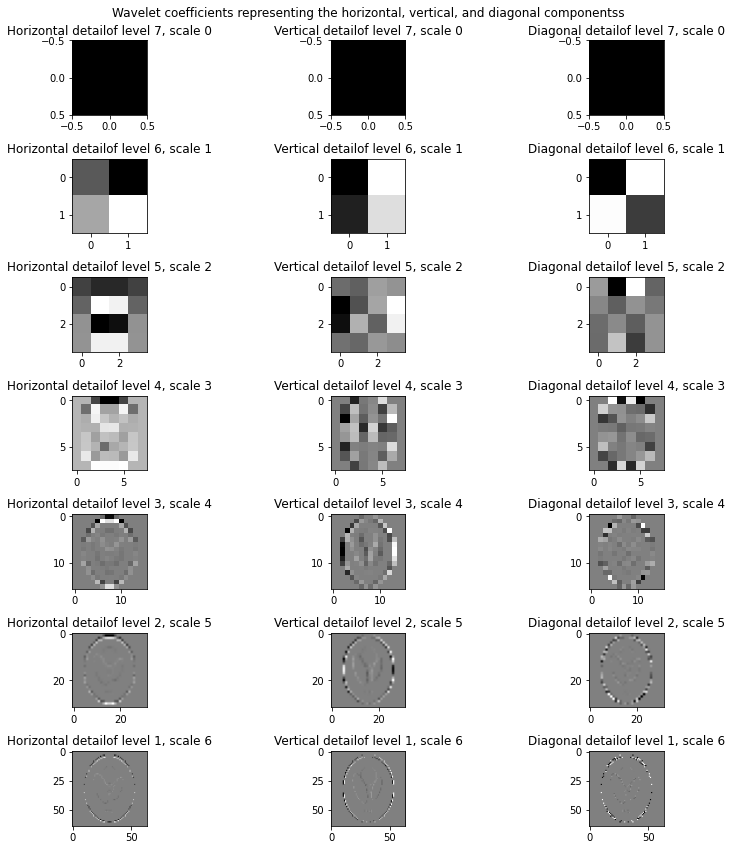

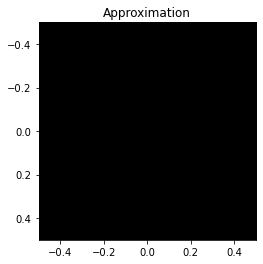

In [ ]:
# Load an example image
# image = data.camera()

# Calculate the Haar wavelet transform of the image
# coeffs = pywt.dwt2(image, 'haar')
# coeffs = pywt.wavedec2(image, 'haar', level = 5)
coeffs = pywt.wavedec2(f_true, 'haar', level = 7)

# Plot the coefficients
titles = ['Approximation', 'Horizontal detail', 'Vertical detail', 'Diagonal detail']
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(12, 12))

for i, c in enumerate(coeffs[1:]):
    # Plot horizontal detail coefficients
    axs[i, 0].imshow(c[0], cmap='gray')
    axs[i, 0].set_title(titles[1] + 'of level ' + str(7-i) + ', scale ' + str(i))
    # Plot vertical detail coefficients
    axs[i, 1].imshow(c[1], cmap='gray')
    axs[i, 1].set_title(titles[2] + 'of level ' + str(7-i) + ', scale ' + str(i))
    # Plot diagonal detail coefficients
    axs[i, 2].imshow(c[2], cmap='gray')
    axs[i, 2].set_title(titles[3] + 'of level ' + str(7-i) + ', scale ' + str(i))
plt.suptitle('Wavelet coefficients representing the horizontal, vertical, and diagonal componentss')
plt.tight_layout()
plt.show()

plt.imshow(coeffs[0], cmap='gray')
plt.title(titles[0])
plt.show()


As we have a 2D image of size (128, 128), after performing a 2D wavelet decomposition using the Haar wavelet, there are 7 scales of wavelet coefficients. For each scale, there are one set or three sets of coefficients representing the Approximation (cA), horizontal (cH), vertical (cV), and diagonal (cD) Detail, respectively.

For the coarsest approximation coefficient (cA7), there is a single set with size 1 of coefficients representing the low-frequency approximation of the image.

For the first scale (cH1, cV1, cD1), there are three sets of coefficients representing the horizontal, vertical, and diagonal details of the image, respectively. These sets of coefficients will be of size (64, 64).

For the subsequent scales, there are three sets of coefficients of decreasing size. For example, for the second scale (cH2, cV2, cD2), we will get sets of coefficients of size (32, 32), and so on.

The wavelet coefficients at the coarser scales (with higher scale index) capture the global features of the image and contain more low-frequency information, while the wavelet coefficients at finer scales (with lower scale index) capture the local features and details. As shown above, for images with more complex and detailed features, the wavelet coefficients at finer scales will be more significant and visible in the plot.

In addition, at the finest scale, the horizontal, vertical, and diagonal detail coefficients represent the high-frequency components of the image, capturing details such as edges and texture. The corresponding plots for the horizontal, vertical, and diagonal detail coefficients look similar. However, there still be some differences due to the specific orientation of the features being captured by each direction. As we move to coarser scales, the detail coefficients capture lower-frequency components and the differences between the horizontal, vertical, and diagonal detail plots become more pronounced.

(2) Reconstruct the image from the coefficients by calling the inverse wavelet transform. Check if your reconstructed image coincides with the original.


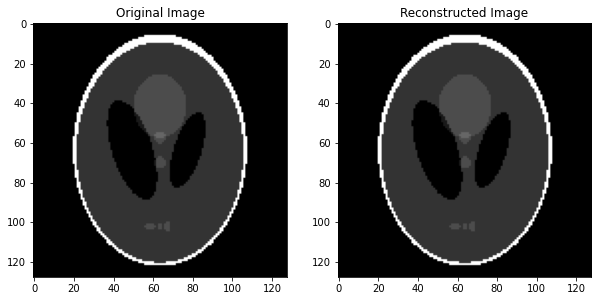

Reconstructed: MSE = 0.00 , PSNR = 310.13 dB. The reconstruction is perfect.


In [ ]:
# Reconstruct image from wavelet coefficients
# reconstructed_image = pywt.idwt2(coeffs, 'haar')
reconstructed_image = pywt.waverec2(coeffs, 'haar')


# Compare original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(f_true, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

mse = np.mean((reconstructed_image - f_true)**2)
psnr = 10 * np.log10(np.max(f_true)**2 / mse)
psnr_values.append(psnr)
print("Reconstructed: MSE = {:.2f} , PSNR = {:.2f} dB. The reconstruction is perfect.".format(mse, psnr))


(3) Write a function that implements thresholding for a given range (the different scales of your wavelet coefficients) and threshold parameter, and form a modified image by performing the inverse wavelet transform on the thresholded coefficients.

(4) Create a noisy version of your original image and perform denoising by thresholding of the wavelet coefficients. Investigate the effect of changing the range and the threshold parameter.

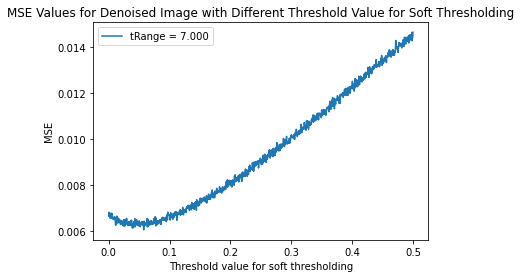

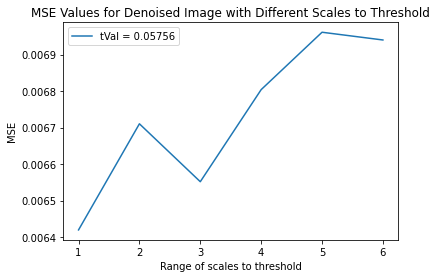

In [ ]:
def threshold(image, tVal, tRange):
    """
    Apply thresholding to the wavelet coefficients.

    Args:
    coeffs: list of tuples, containing wavelet coefficients
    tVal: float, the threshold value for soft thresholding
    tRange: int, indicating the scales to threshold

    Returns:
    list of tuples, modified wavelet coefficients
    """
    
    # Apply thresholding to specified scales
    assert tRange <= 7, "The maximum scale for an image of size 128×128 is 7."
    
    noise = np.random.normal(0, 0.1, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 1)

    coeffs = pywt.wavedec2(noisy_image, 'haar', mode='periodization', level=7)

    for i in range(tRange):
        coeffs[i] = tuple(pywt.threshold(c, tVal, mode='soft') for c in coeffs[i])
        
    denoised_image = pywt.waverec2(coeffs, 'haar', mode='periodization')

    mse = np.mean((denoised_image - image)**2)
    psnr = 10 * np.log10(np.max(image)**2 / mse)

    # # Plot the original, noisy, and denoised images
    # fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    # axs[0].imshow(image, cmap='gray')
    # axs[0].set_title('Original Image')
    # axs[1].imshow(noisy_image, cmap='gray')
    # axs[1].set_title('Noisy Image')
    # axs[2].imshow(denoised_image, cmap='gray')
    # axs[2].set_title('Denoised Image')
    # plt.suptitle(f'Threshold value = {tVal:.2f}, scales of wavelet coefficients = {tRange}')
    # plt.show()

    return mse


# choose a threshold value.
mse_list = []
tRange=7
for tVal in np.linspace(0,0.5,1000):
    mse = threshold(f_true, tVal=tVal, tRange=7)
    mse_list.append(mse)
plt.plot(np.linspace(0,0.5,1000),mse_list,label='tRange = {:.3f}'.format(tRange))
plt.xlabel('Threshold value for soft thresholding')
plt.ylabel('MSE')
plt.title('MSE Values for Denoised Image with Different Threshold Value for Soft Thresholding')
plt.legend()
plt.show()
min_index = np.argmin(mse_list)
tVal = np.linspace(0,0.5,1000)[min_index]



# Different Scales to Threshold 
maxRange = 7
mse_list = []
for tRange in range(1,maxRange):
    mse = threshold(f_true, tVal = tVal, tRange=tRange)
    mse_list.append(mse)
plt.plot(range(1,maxRange),mse_list,label='tVal = {:.5f}'.format(tVal))
plt.xlabel('Range of scales to threshold')
plt.ylabel('MSE')
plt.title('MSE Values for Denoised Image with Different Scales to Threshold')
plt.legend()
plt.show()




After the lowest point in the plot, the increasing MSE with threshold value could be due to the fact that higher threshold values result in more aggressive removal of wavelet coefficients, leading to a greater loss of information and hence higher MSE.

Furthermore, the MSE is not change proportionally to the range of the scale of the wavelet coefficients. The effect of changing the range of scale of wavelet coefficients on the MSE may depend on the specific image and noise characteristics. In some cases, the higher scales may contain more noise and removing those components may lead to a larger reduction in the MSE. In other cases, the lower scales may contain more important image features and removing those components may lead to a larger increase in the MSE.

## 5. Iterative soft-thresholding for X-ray tomography.

The aim of this exercise is to write your own sparsity promoting reconstruction algorithm for
X-ray tomography, by solving
$$\frac{1}{2}||Af − g||^2_2 + α||Wf||_1 → min$$
where $W$ denotes the wavelet transform. To achieve this we use iterative soft-thresholding with Haar wavelets.

You need to implement an iterative algorithm that performs the update equation:
$$f_{k+1} = S_{α,W}(f_k − λA^T(Af_k − g))$$

Here $S_{α,W}$ is the soft-thresholding operator given in lectures,
$$S_{α,W}(f) = W^{-1}S_{\mu}Wf$$

This process is equivalent to the denoiser from Task 4, where $S_µ$ is given by your threshold function with threshold parameter $µ = αλ$ as discussed in the lecture.

In order to have a full algorithm you need consider the following points:
1. Define an initial iterate $f_0$
2. Choose a suitable stopping criterion for the algorithm
3. Choose a stable step size λ: Start with a small value $λ << 1$ and make sure that the reconstruction gets better each step. Increase it gradually to converge faster.
4. Include more prior knowledge, e.g. non-negativity.
5. Evaluate the algorithm for varying noise levels and projection geometries (low number of angles/limited angle).




In [14]:
import numpy as np
import pywt

def soft_threshold(f, alpha, lambda_, tRange):
    """
    Soft thresholding function.

    Args:
    f: numpy array, input data
    alpha: float, threshold parameter
    lambda_: float, threshold parameter
    tRange:int, indicating the scales to threshold

    Returns:
    numpy array, thresholded data S(f)
    """
    Wf = pywt.wavedec2(f, 'haar', mode='periodization', level=7)

    for i in range(tRange):
        Wf[i] = tuple(pywt.threshold(c, tVal=alpha*lambda_, mode='soft') for c in Wf[i])
    SWf = Wf

    WTSWf = pywt.waverec2(SWf, 'haar', mode='periodization')

    # mse = np.mean((denoised_image - image)**2)
    # psnr = 10 * np.log10(np.max(image)**2 / mse)

    return WTSWf #np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def iterative_soft_thresholding(f, lambda_, alpha, tRange, max_iter=100, tol=1e-4):
    """
    Iterative soft-thresholding algorithm for X-ray tomography.

    Args:
    f: numpy array, original image
    lambda_:  float, step length
    alpha: float, regularization parameter
    tRange:int, indicating the scales to threshold
    max_iter: int, maximum number of iterations
    tol: float, tolerance for stopping criterion

    Returns:
    numpy array, reconstructed image
    """
    # Define initial iterate
    fk = np.zeros(f.shape)
    # record for stopping criterion 
    f=[fk]
    
    # forward g
    # Define volume geometry
    if f.ndim == 2:
        f = f
    elif f.ndim == 1:
        size = int(np.sqrt(f.shape))
        f = f.reshape((size,size))
        
    vol_geom = astra.create_vol_geom(f.shape[0], f.shape[1])
    
    # Define detector geometry
    det_count = int(np.sqrt(2) * f.shape[0])
    proj_geom = astra.create_proj_geom('parallel', 1., det_count, theta=np.linspace(0, 180, 180))
    
    # Create projector and sinogram IDs
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    g_id, g = astra.create_sino(f, projector_id)

    for i in range(max_iter):
        # Create sinogram ID for current iterate
        fk_id, fk = astra.create_sino(fk, projector_id)
        
        # Compute difference between current iterate and measured sinogram
        diff_id = astra.data2d.create('-sino', proj_geom, g - fk)
        
        # Apply filtered backprojection to compute AT(Afk-g)
        ATA_id = astra.data2d.create('-vol', vol_geom)
        cfg = astra.astra_dict('FBP')
        cfg['ReconstructionDataId'] = ATA_id
        cfg['ProjectionDataId'] = diff_id
        cfg['ProjectorId'] = projector_id
        alg_id = astra.algorithm.create(cfg)
        astra.algorithm.run(alg_id)
        ATA = astra.data2d.get(ATA_id)

        # Compute new iterate using soft thresholding
        renew = fk - lambda_ * ATA
        fk = soft_threshold(renew, alpha, lambda_, tRange)
        f.append(fk)

        # Check stopping criterion
        if np.mean((f[i+1] - f[i])**2) < tol:
            break

    return fk


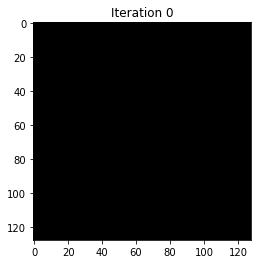

AttributeError: 'list' object has no attribute 'ndim'

In [15]:
# Define lambda values to test
lambda_values = np.logspace(-4, -1, num=10)

# Define initial iterate
fk = np.zeros(f_true.shape)

# Plot initial reconstruction
plt.figure()
plt.imshow(fk, cmap='gray')
plt.title('Iteration 0')
plt.show()

# Loop over lambda values and perform iterative soft thresholding
for i, lambda_ in enumerate(lambda_values):
    # Perform iterative soft thresholding
    fk = iterative_soft_thresholding(f_true, lambda_, alpha = 0.1, tRange=7, max_iter=100, tol=1e-4)

    # Plot current reconstruction
    plt.figure()
    plt.imshow(fk, cmap='gray')
    plt.title('Iteration {}'.format(i+1))
    plt.show()

    # Check if iterations are stable
    if i > 0:
        mse_prev = np.mean((f_prev - f_true)**2)
        mse_current = np.mean((fk - f_true)**2)
        if mse_current > mse_prev:
            print('Iterations are not stable for lambda =', lambda_)
            break

    # Store current reconstruction for comparison in next iteration
    f_prev = fk


In [ ]:
num_angles_list = [5, 9, 12, 15, 18, 20, 30, 36, 45, 60, 90, 180]
max_angles_list = np.linspace(15, 180, 12, endpoint=True)

mse_list = []
for num_angles in num_angles_list:
    noisy_sinogram = astra.functions.add_noise_to_sino(sinogram, I0=60)
    f_rec1 = solve_unreg_ls(noisy_sinogram, theta)
    mse_list.append(np.mean((f_rec1 - f_true)**2))

for max_angles in max_angles_list:
    noisy_sinogram = astra.functions.add_noise_to_sino(sinogram, I0=60)
    f_rec1 = solve_unreg_ls(noisy_sinogram, theta)
    mse_list.append(np.mean((f_rec1 - f_true)**2))

plt.figure(figsize=(10,6))
plt.plot(np.arange(len(mse_list)), mse_list, '.')
plt.title('MSE for iterative soft-thresholding')
plt.xlabel('Experiment')
plt.ylabel('MSE')
plt.show()
